In [1]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession

import string
import numpy as np
import pandas as pd
from os import path
from PIL import Image

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

In [2]:
my_spark = SparkSession .\
    builder .\
    appName("myApp") .\
    config("spark.mongodb.input.uri", "mongodb://13.76.131.54:27017/cord19dataset.fulltexts") .\
    config("spark.mongodb.output.uri", "mongodb://13.76.131.54:27017/cord19dataset.fulltexts") .\
    config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.0").\
    getOrCreate()

In [3]:
df = my_spark.read.format("mongo").load()
#df.printSchema()

In [4]:
df1=df.select("abstract.text")
df2=df1.withColumn("abs",df1["text"].getItem(0))
df3=df2.select("abs")
#df3.printSchema()

In [5]:
df3=df3.na.drop(subset=["abs"])
#df3.show()

In [6]:
from pyspark.sql.functions import *
from pyspark.ml.feature import NGram, VectorAssembler
from pyspark.ml.feature import CountVectorizer
 
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StopWordsRemover
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
def build_trigrams(inputCol="abs", n=3):
    tokenizer = [Tokenizer(inputCol="abs", outputCol="words")]
    remover= [StopWordsRemover(inputCol='words', outputCol='words_clean')]
    ngrams = [
        NGram(n=i, inputCol="words_clean", outputCol="{0}_grams".format(i))
        for i in range(1, n + 1)
    ]
 
    cv = [
        CountVectorizer(vocabSize=2**14,inputCol="{0}_grams".format(i),
            outputCol="{0}_tf".format(i))
        for i in range(1, n + 1)
    ]
    idf = [IDF(inputCol="{0}_tf".format(i), outputCol="{0}_tfidf".format(i), minDocFreq=5) for i in range(1, n + 1)]
 
    assembler = [VectorAssembler(
        inputCols=["{0}_tfidf".format(i) for i in range(1, n + 1)],
        outputCol="features"
    )]
    return Pipeline(stages=tokenizer + remover+ngrams + cv + idf+ assembler)

In [7]:
trigram_data = build_trigrams().fit(df3)

In [8]:
df4=trigram_data.transform(df3)
#df4.printSchema()

In [9]:
grams_1=df4.select("1_grams").toPandas()
grams_2=df4.select("2_grams").toPandas()
grams_3=df4.select("3_grams").toPandas()
total=grams_1.shape[0]
#grams_1

In [10]:
freq_count = {}

for grams in grams_1['1_grams']:
    freq_set = set(grams)
    for gram in freq_set:
        if gram in freq_count.keys():
            freq_count[gram] += 1
        else:
            freq_count[gram] = 1

In [11]:
sorted_grams = {k: v for k, v in sorted(freq_count.items(), key=lambda item: item[1], reverse=True)}
#sorted_grams

In [12]:
list1=['covid-19','disease','pandemic','sars-cov-2','study','respiratory','syndrome','infection','viral','health']
correlation_matrix = [[0 for i in range(10)] for j in range(10)]
corr_matrix = [[0 for i in range(10)] for j in range(10)]

In [13]:
for i in range(10):
    word1=list1[i]
    for j in range(i+1,10):
        word2=list1[j]
        for grams in grams_1['1_grams']:
            freq_set = set(grams)
            flag1=False
            flag2=False
            for gram in freq_set:
                if gram==word1:
                    flag1=True
                if gram==word2:
                    flag2=True
                if flag1==True & flag2==True:
                    correlation_matrix[i][j]+=1
                    break

for i in range(10):
    for j in range(10):
        correlation_matrix[j][i]=correlation_matrix[i][j]

for i in range(10):
    for j in range(10):
        if(i==j):
            corr_matrix[i][j]=1
        else:
            corr_matrix[i][j]=correlation_matrix[i][j]/total
            
d = pd.DataFrame(corr_matrix,columns=list1,index=list1)
#d

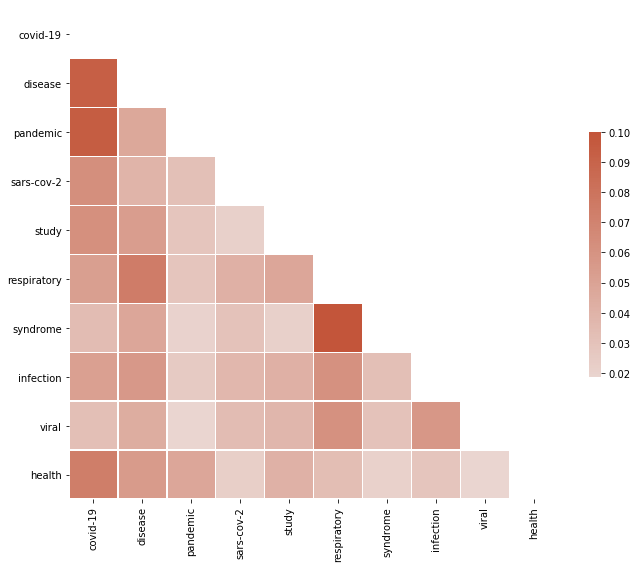

In [14]:
mask = np.triu(np.ones_like(d, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(d, mask=mask, cmap=cmap, vmax=.1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [15]:
freq_count = {}

for grams in grams_2['2_grams']:
    freq_set = set(grams)
    for gram in freq_set:
        if gram in freq_count.keys():
            freq_count[gram] += 1
        else:
            freq_count[gram] = 1

In [16]:
sorted_grams2 = {k: v for k, v in sorted(freq_count.items(), key=lambda item: item[1], reverse=True)}
#sorted_grams2

In [17]:
freq_count = {}

for grams in grams_3['3_grams']:
    freq_set = set(grams)
    for gram in freq_set:
        if gram in freq_count.keys():
            freq_count[gram] += 1
        else:
            freq_count[gram] = 1

In [18]:
sorted_grams3 = {k: v for k, v in sorted(freq_count.items(), key=lambda item: item[1], reverse=True)}
#sorted_grams3

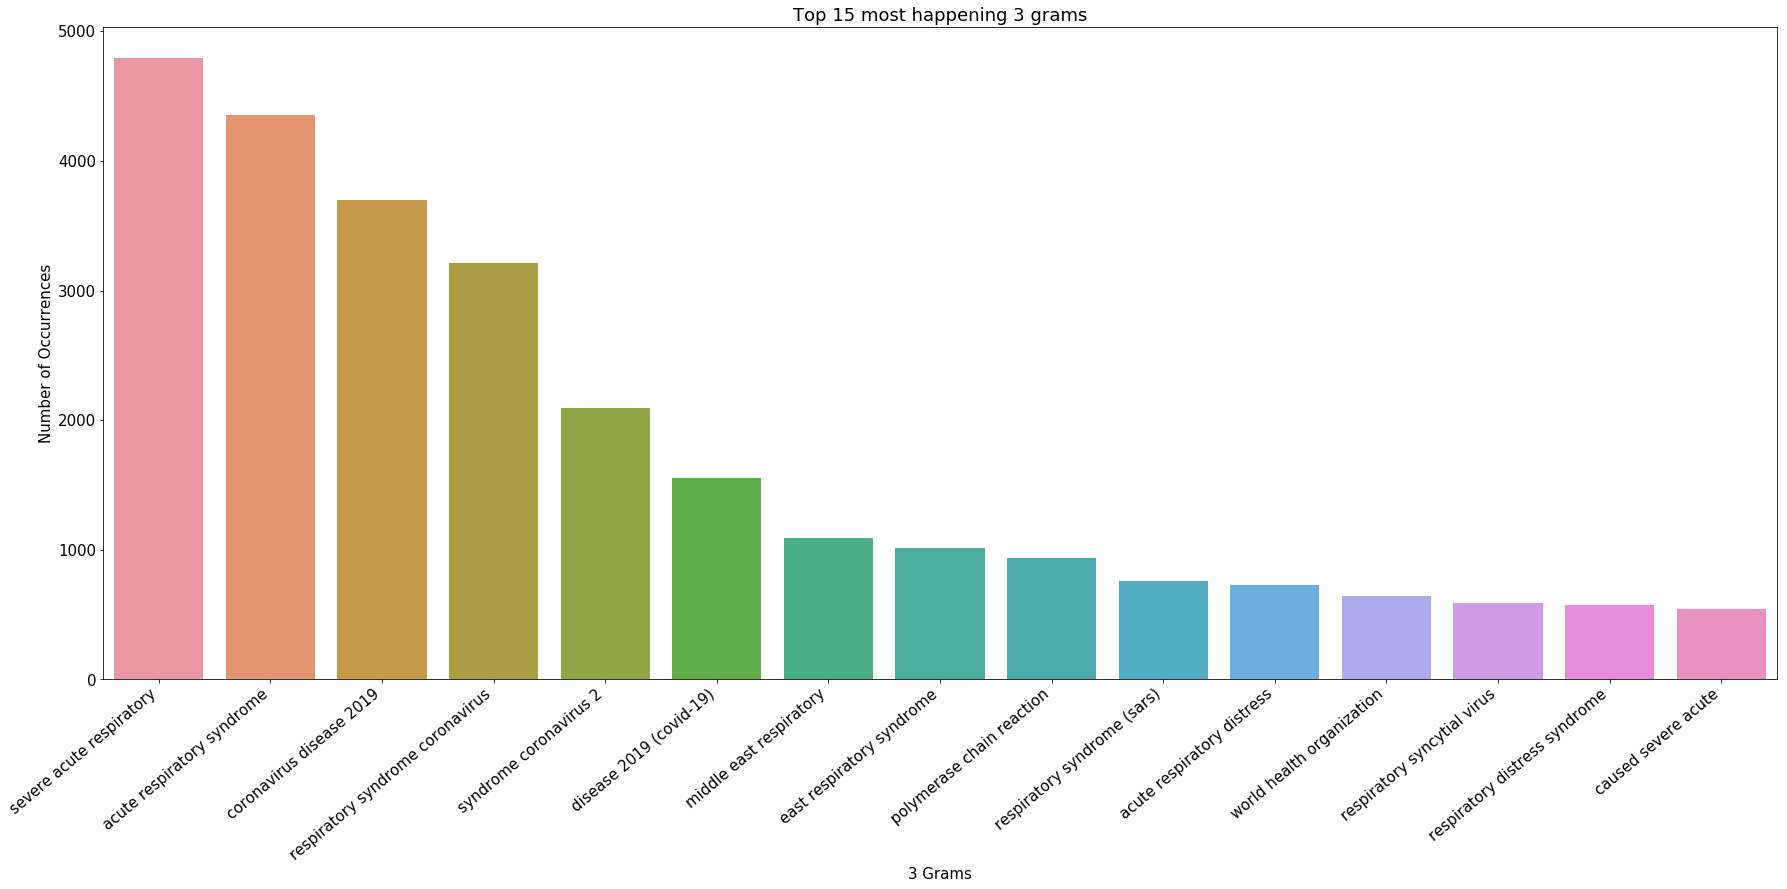

In [19]:
indices=[0,1,2,3,4,17,19,20,21,22,23,24,27,28,29]
x = list(sorted_grams3.keys())
y = list(sorted_grams3.values())
x = [x[i] for i in indices]
y = [y[i] for i in indices]
font = {'size':15}
plt.rc('font', **font)
plt.figure(figsize=(30,12))
plt.xlabel("3 Grams")
plt.ylabel("Number of Occurrences")
plt.title("Top 15 most happening 3 grams")
bar = sns.barplot(x=x,y=y)
bar.set_xticklabels(bar.get_xticklabels(), rotation=40, ha="right")
plt.savefig('top15_3grams')
plt.show()

In [20]:
data=df4.select("abs").toPandas()
data_clean=df4.select("words_clean").toPandas()
data1=[0 for i in range(57957)]
for i in range(57957):
    data1[i]=' '.join(map(str, data_clean['words_clean'][i])) 

In [21]:
tfidf_vectorizer=TfidfVectorizer(use_idf=True)
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(data1)

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters
Fit 22 clusters
Fit 24 clusters
Fit 26 clusters
Fit 28 clusters
Fit 30 clusters
Fit 32 clusters
Fit 34 clusters
Fit 36 clusters


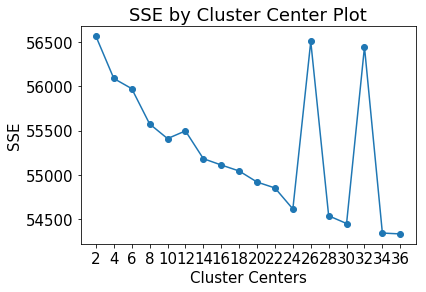

In [24]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(tfidf_vectorizer_vectors, 36)

In [25]:
clusters = MiniBatchKMeans(n_clusters=24, init_size=1024, batch_size=2048, random_state=20).fit_predict(tfidf_vectorizer_vectors)

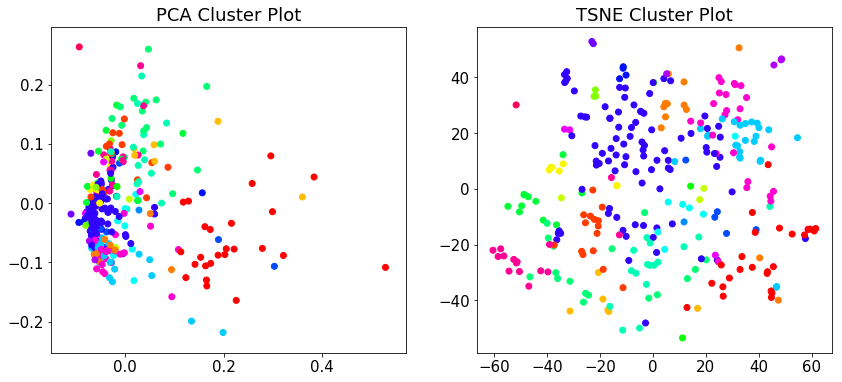

In [26]:
def plot_tsne_pca(data, labels):
    max_label = 24
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(tfidf_vectorizer_vectors, clusters)

In [27]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(tfidf_vectorizer_vectors, clusters, tfidf_vectorizer.get_feature_names(), 5)


Cluster 0
mers,respiratory,coronavirus,sars,cov

Cluster 1
patients,19,covid,pandemic,care

Cluster 2
sequences,genome,ibv,virus,viruses

Cluster 3
wuhan,ncov,disease,coronavirus,2019

Cluster 4
global,infectious,diseases,public,health

Cluster 5
2009,viruses,virus,h1n1,influenza

Cluster 6
les,el,en,la,de

Cluster 7
diarrhea,distress,respiratory,ards,calves

Cluster 8
patients,19,or,95,ci

Cluster 9
pandemic,health,19,covid,social

Cluster 10
pandemic,disease,background,19,covid

Cluster 11
clinical,ct,19,covid,patients

Cluster 12
tract,viruses,viral,infections,respiratory

Cluster 13
virus,viral,rna,proteins,protein

Cluster 14
infections,hbov,respiratory,rsv,children

Cluster 15
samples,assay,detection,rt,pcr

Cluster 16
references,text,abstract,count,word

Cluster 17
research,disease,article,doi,study

Cluster 18
covid,abstract,pre,journal,proof

Cluster 19
virus,epidemic,porcine,diarrhea,pedv

Cluster 20
lockdown,medical,education,learning,students

Cluster 21
virus,infection,im